In [1]:
import lmdb
import numpy as np
from pathlib import Path
from random import sample, choice
from io import BytesIO
from PIL import Image

## Data

In [2]:
env = lmdb.open(
    str(Path("data") / "DocTamperV1-SCD"),
    readonly=True,
    lock=False,
    readahead=False,
    meminit=False
)

def list_files_codes(env: lmdb.Environment):
    '''
    List files awailable in the lmdb.Environment.

    Parameters
    ----------
    env: lmdb.Environment
        Environment from wich files must me loaded.
    '''
    with env.begin(write=False) as txn:
        with txn.cursor() as cursor:
            decoded: list[str] = [key.decode('utf-8') for key, _ in cursor]
            image_predix = "image-"
            return [
                name[len(image_predix):] 
                for name in decoded if name.startswith(image_predix)
            ]

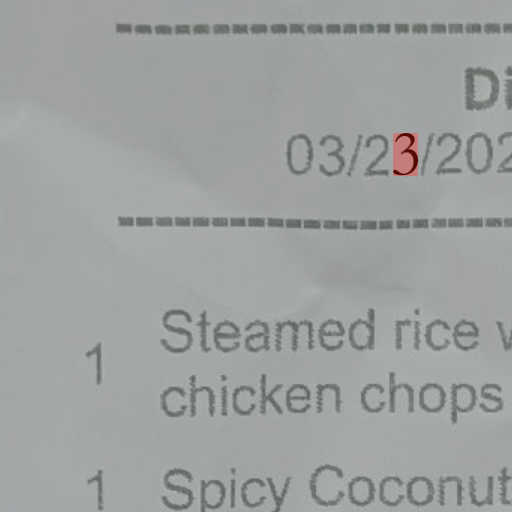

In [3]:
index = choice(list_files_codes(env=env))

with env.begin(write=False) as txn:
    img_buf = txn.get(f'image-{index}'.encode('utf-8'))
    label_buf = txn.get(f'label-{index}'.encode('utf-8'))

image = Image.open(BytesIO(img_buf)).convert("RGBA")

mask = Image.open(BytesIO(label_buf))
mask = np.array(mask)

mask = np.transpose(
    np.stack([
        np.where(mask == 255, 255, 0),
        np.zeros_like(mask),
        np.zeros_like(mask),
        np.where(mask == 255, 255, 0)
    ]),
    (1,2,0)
)
mask = Image.fromarray(mask.astype(np.uint8))

Image.blend(im1=image, im2=mask, alpha=0.3)

## Model

In [4]:
import sys
sys.path.append(str(Path().resolve()/"models"))

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import six
import pickle
import tempfile
from tqdm import tqdm
from models.dtd import seg_dtd
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from swins import BasicLayer, SwinTransformerBlock, WindowAttention, Mlp, PatchMerging

/home/f.kobak@maxbit.local/Documents/DocTamper/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/f.kobak@maxbit.local/Documents/DocTamper/venv/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [5]:
device=torch.device("cpu")
model = seg_dtd("", 2).to(device)
model = nn.DataParallel(model)
loader = torch.load(Path("pths")/"dtd_doctamper.pth", map_location='cpu')['state_dict']
model.load_state_dict(loader)

/home/f.kobak@maxbit.local/Documents/DocTamper/venv/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


<All keys matched successfully>

In [6]:
from dataloader import TamperDataset

dataset = TamperDataset(
    str(Path("data")/"DocTamperV1-SCD"), False, 
    minq=75, 
    pickle_path=Path("pks")/"DocTamperV1-SCD_75.pk"
)

In [7]:
def add_mask(image: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    image = image.clone()
    image[0] = (image[0] + mask*3)
    return image/2

/home/f.kobak@maxbit.local/Documents/DocTamper/venv/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


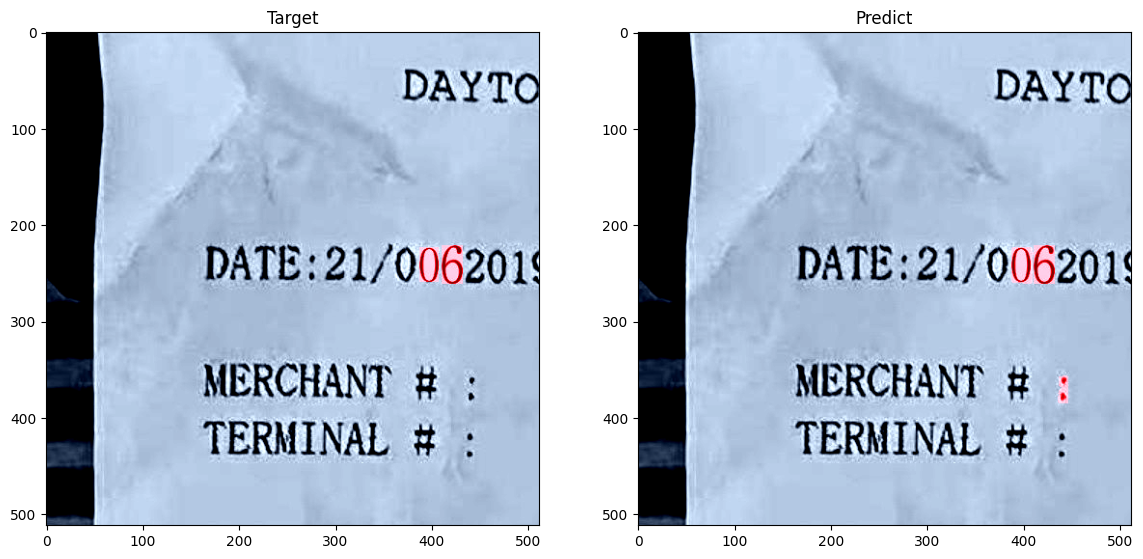

In [8]:
sample = dataset[17]

data, target, dct_coef, qs, q = (
    sample['image'].unsqueeze(0), 
    sample['label'].unsqueeze(0),
    torch.tensor(sample['rgb']).unsqueeze(0), 
    sample['q'].unsqueeze(0), 
    sample['i']
)
data, target, dct_coef, qs = (
    data.to(device), 
    target.to(device), 
    dct_coef.to(device), 
    qs.unsqueeze(1).to(device)
)

pred = model(data,dct_coef,qs)               
pred = pred.argmax(1)

plt.figure(figsize=[14,10])

plt.subplot(121)
plt.title("Target")
show_target = add_mask(image=sample['image'], mask=target)
plt.imshow(torch.permute(show_target, (1,2,0)))

plt.subplot(122)
plt.title("Predict")
show_predict = add_mask(image=sample['image'], mask=pred)
plt.imshow(torch.permute(show_predict, (1,2,0)))

plt.show()